In [2]:
import numpy as np
import gbm
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial
from astropy.io import fits
from functions import find_files


In [3]:
# reduce gbm data
# select the fermi id of the burst
fermi_id = "bn251222712"
energy_range = (8, 1000)  # in keV
bin_time = 0.064  # in seconds
bin_time_str = str(int(bin_time*1000))
bin_time_rb = 1.024  # in seconds for the background
rebf = int(bin_time_rb / bin_time)
# test if the data is already downloaded by checking if the folder exists
data_folder = f"./{fermi_id}"
if not os.path.exists(data_folder):
    # write a line of code from the terminal to download the data
    os.system(f"../take_GBM_burst_data.sh {fermi_id}")
if not os.path.exists(f"{fermi_id}/LC"):
    os.makedirs(f"{fermi_id}/LC")

In [8]:

file_path_bcat = find_files(f'{fermi_id}/glg_bcat_all_{fermi_id}_v*.fit')

filename = file_path_bcat
with fits.open(filename) as hdul:
    # Access the Primary Header (Metadata)
    header = hdul[0].header
    t90 = hdul[0].header['T90']
    t90_start = hdul[0].header['T90START']
    # Print every line ("Card") nicely
    print(f"{'KEYWORD':<10} = {'VALUE':<20} / {'COMMENT'}")
    print("-" * 60)
    
    for card in header.cards:
        print(card)

Using the latest version: bn251222712/glg_bcat_all_bn251222712_v01.fit
KEYWORD    = VALUE                / COMMENT
------------------------------------------------------------
SIMPLE  =                    T /Written by IDL:  Mon Dec 22 23:47:15 2025       
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T /File contains extensions                        
DATE    = '2025-12-23T04:47:16' /                                               
FILETYPE= 'SPECTRAL FITS'      /Unique FITS file type name                      
CREATOR = 'rmfit 4.4.2BA'      /Software/version creating file                  
ORIGIN  = 'GIOC    '           /Name of organization                            
TELESCOP= 'GLAST   '           /Name of mission                                 
INSTRUME= 'GBM     '           /Name of instrument                              
OBSERVER= 'Mee

In [9]:
file_path_tcat = find_files(f'{fermi_id}/glg_tcat_all_{fermi_id}_v*.fit')

with fits.open(file_path_tcat) as hdul:
    # The mask is usually in the Primary header (index 0)
    det_mask = hdul[0].header['DET_MASK']
    detectors = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1']
    used_detectors = [det for i, det in enumerate(detectors) if det_mask[i] == '1']
    print(f"Used Detectors: {used_detectors}")
    # convert used_detectors to a str separated by _
    used_detectors_str = '_'.join(used_detectors)

Using the latest version: bn251222712/glg_tcat_all_bn251222712_v01.fit
Used Detectors: ['n1', 'n7', 'na', 'nb']


In [10]:
tte_files=[]
ttes=[]
for det in used_detectors:
    tte_files.append(find_files(f'{fermi_id}/glg_tte_{det}_{fermi_id}_v*.fit'))
    ttes.append(TTE.open(tte_files[-1]))
tte_files


det_time, det_counts, det_err_counts = [], [], []
for det in ttes:
    phaii = det.to_phaii(bin_by_time, bin_time, time_ref = 0.0)
    lc = phaii.to_lightcurve(energy_range = energy_range)
    counts = lc.counts 
    err_counts = np.sqrt(lc.counts+3/4)+1
    time = lc.centroids
    det_time.append(time)
    det_counts.append(counts)
    det_err_counts.append(err_counts)

Using the latest version: bn251222712/glg_tte_n1_bn251222712_v00.fit
Using the latest version: bn251222712/glg_tte_n7_bn251222712_v00.fit
Using the latest version: bn251222712/glg_tte_na_bn251222712_v00.fit
Using the latest version: bn251222712/glg_tte_nb_bn251222712_v00.fit


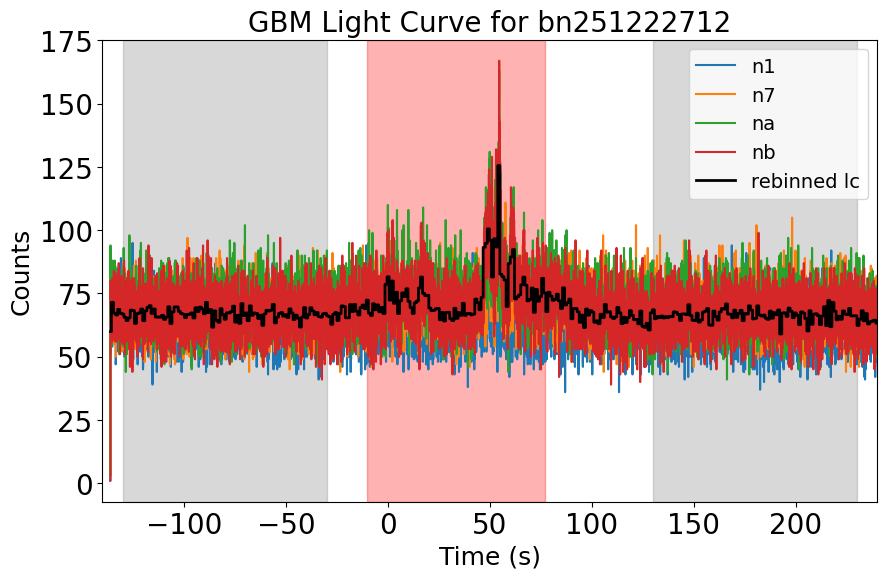

In [11]:
# choose the bkgd intervals
bkgd_intervals = [(-130, -30), (130, 230)]
t1, t2, t3, t4 = bkgd_intervals[0][0], bkgd_intervals[0][1], bkgd_intervals[1][0], bkgd_intervals[1][1]
plt.figure(figsize=(10,6))
# plot the light curve for all used detectors
for i, det in enumerate(used_detectors):
    plt.step(det_time[i], det_counts[i], where='mid', label=det)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# rebin the light curve to 1s
import sys
from turtle import bk

from numpy import average 
sys.path.append('/astrodata/romain/')
from sax_utils import rebin_lc_genau


x_reb,y_reb,z_reb = rebin_lc_genau(det_time[-1], det_counts[-1], det_err_counts[-1],rebf,ren=True)

plt.step(x_reb, y_reb, where='mid', label='rebinned lc', color='k', linewidth=2)
plt.axvspan(bkgd_intervals[0][0],bkgd_intervals[0][1], color='gray', alpha=0.3)
plt.axvspan(bkgd_intervals[1][0],bkgd_intervals[1][1], color='gray', alpha=0.3)
plt.axvspan(t90_start, t90_start+t90, color='red', alpha=0.3)
#plt.xlim(t90_start-0.5*t90, t90_start+3*t90)
plt.xlim(bkgd_intervals[0][0]-10, bkgd_intervals[1][1]+10)
plt.title(f'GBM Light Curve for {fermi_id}', fontsize=20)
plt.legend(fontsize=14)


In [ ]:
################################################################
# Find the intersection of all detectors' time
###############################################################
t11 = np.max([det_time[kk][0] for kk in range(len(det_time))])
t22 = np.min([det_time[kk][-1] for kk in range(len(det_time))])

for jj in range(len(det_time)):
    ind = np.where(  (det_time[jj]>t11) & (det_time[jj]<t22) )[0]
    det_time[jj] = det_time[jj][ind]
    det_counts[jj] = det_counts[jj][ind]
    det_err_counts[jj] = det_err_counts[jj][ind]

-136.096 478.36800000000005


-->  Deg 3 polynomial parameters: [ 1.83247982e-07 -6.00806747e-05 -7.26771751e-03  2.69376336e+02]
Residuals Mean: 0.010409624306568846, Std: 1.830216200093437


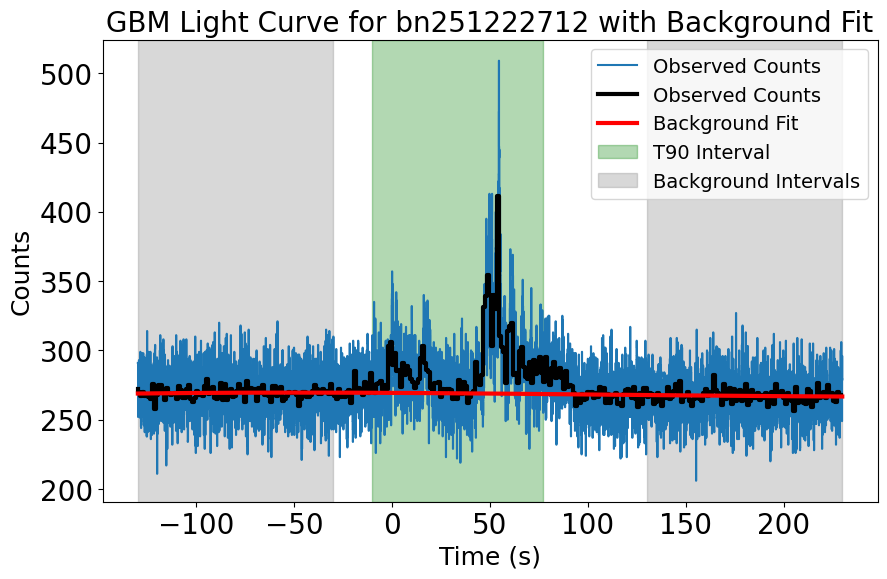

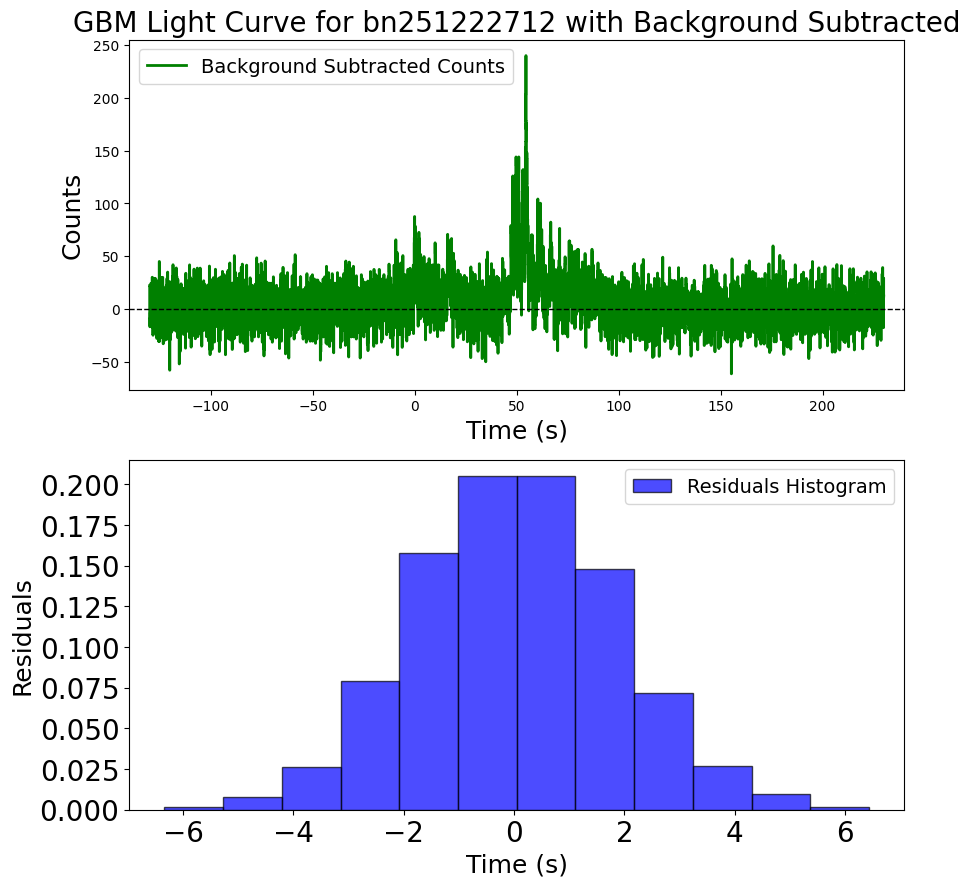

In [13]:
# sum the counts of all used detectors
time = det_time[0]

counts_tot = np.zeros(len(det_counts[0]))
counts_tot_reb = np.zeros(len(x_reb))
for k in range(len(det_counts)):
    counts_tot+= det_counts[k]
    x_reb_det,y_reb_det,z_reb_det = rebin_lc_genau(det_time[k], det_counts[k], det_err_counts[k],rebf,ren=True)
    counts_tot_reb += y_reb_det

det_err_counts_tot_squared= np.zeros(len(det_counts[0]))
det_err_counts_tot_squared_reb= np.zeros(len(x_reb))

for k in range(len(det_counts)):
    det_err_counts_tot_squared+= det_err_counts[k]**2
    det_err_counts_tot_squared_reb+= (z_reb_det)**2

err_counts_tot = np.sqrt(det_err_counts_tot_squared)
err_counts_tot_reb = np.sqrt(det_err_counts_tot_squared_reb)

idx_bkgds_reb = np.where( (x_reb > t1) & (x_reb < t2) | (x_reb > t3) & (x_reb < t4) )[0]
time_bkgds_reb,cts_bkgds_reb,err_bkgds_reb = x_reb[idx_bkgds_reb], counts_tot_reb[idx_bkgds_reb], err_counts_tot_reb[idx_bkgds_reb]

idx_cut = np.where( (x_reb > t1) & (x_reb < t4) )[0]
time_cut_reb,counts_tot_cut_reb,err_counts_tot_cut_reb = x_reb[idx_cut], counts_tot_reb[idx_cut], err_counts_tot_reb[idx_cut]


# do the same for the unrebinned data
idx_bkgds = np.where( (time > t1) & (time < t2) | (time > t3) & (time < t4) )[0]
time_bkgds,cts_bkgds,err_bkgds = time[idx_bkgds], counts_tot[idx_bkgds], err_counts_tot[idx_bkgds]
idx_cut = np.where( (time > t1) & (time < t4) )[0]

time_cut,counts_tot_cut,err_counts_tot_cut = time[idx_cut], counts_tot[idx_cut], err_counts[idx_cut]


deg = 3
bin_time_rb = 1.024
p_bg_tot, cov = np.polyfit(time_bkgds_reb,cts_bkgds_reb,deg,w=1/err_bkgds_reb, full = False, cov = True)
print('-->  Deg {0} polynomial parameters:'.format(deg), p_bg_tot)
bg_poly_tot = np.polyval(p_bg_tot, time_cut)
bg_mean = np.mean(bg_poly_tot)

counts_no_bkgd_tot_cut = counts_tot_cut - bg_poly_tot

residuals_tot = counts_no_bkgd_tot_cut/ err_counts_tot_cut

plt.figure(figsize=(10,6))
#plt.step(time_cut, residuals_tot, where='mid', label='Residuals')

plt.step(time_cut,counts_tot_cut, where='mid', label='Observed Counts', markersize=4)
plt.step(time_cut_reb,counts_tot_cut_reb, label='Observed Counts', markersize=4,lw=3,color='k')
plt.plot(time_cut,bg_poly_tot, color='red', label='Background Fit', linewidth=3)
plt.axvspan(t90_start, t90_start+t90, color='green', alpha=0.3,label='T90 Interval')
plt.axvspan(t1, t2, color='gray', alpha=0.3,label='Background Intervals')
plt.axvspan(t3, t4, color='gray', alpha=0.3)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(f'GBM Light Curve for {fermi_id} with Background Fit', fontsize=20)
plt.legend(fontsize=14)
# other figure with the bkdg subtracted lc and the residuals (make two panels)
fig,axs = plt.subplots(2,1, figsize=(10,10))
axs[0].step(time_cut, counts_no_bkgd_tot_cut, where='mid', label='Background Subtracted Counts', color='green', linewidth=2)
axs[0].axhline(0, color='black', linestyle='--', linewidth=1)
axs[0].set_ylabel('Counts', fontsize=18)
axs[0].set_xlabel('Time (s)', fontsize=18)
axs[0].set_xlim(t1-10, t4+10)
axs[0].set_title(f'GBM Light Curve for {fermi_id} with Background Subtracted', fontsize=20)

axs[0].legend(fontsize=14)

# take between t1 and t2  or t3 and t4
counts_no_bkgd_tot_cut = counts_tot_cut - bg_poly_tot
counts_no_bkgd_tot_cut2 = counts_no_bkgd_tot_cut[(time_cut > t1) & (time_cut < t2) | (time_cut > t3) & (time_cut < t4)]
err_counts_tot_cut2 = err_counts_tot_cut[(time_cut > t1) & (time_cut < t2) | (time_cut > t3) & (time_cut < t4)]
residuals_tot = counts_no_bkgd_tot_cut2/ err_counts_tot_cut2
axs[1].hist(residuals_tot,bins=12, density=True, alpha=0.7, color='blue', label='Residuals Histogram',edgecolor='black')
#axs[1].axhline(0, color='black', linestyle='--', linewidth=1)
axs[1].set_xlabel('Time (s)', fontsize=18)
axs[1].set_ylabel('Residuals', fontsize=18)
axs[1].legend(fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# print residuals statistics
mean_res = np.mean(residuals_tot)
std_res = np.std(residuals_tot)
print(f'Residuals Mean: {mean_res}, Std: {std_res}')

In [14]:
# save selected units
np.savetxt(f'{fermi_id}/LC/selected_units.txt', used_detectors,fmt="%s")
# save bkgd time int 
np.savetxt(f'{fermi_id}/LC/bkgd_time_int.txt', np.array(bkgd_intervals),fmt="%1.2f")
# save poly coeffs
np.savetxt(f'{fermi_id}/LC/bg_poly_coeffs_{bin_time_str}ms.txt', p_bg_tot,fmt="%1.6e")
# save poly order 
with open(f'{fermi_id}/LC/bg_poly_order_{bin_time_str}ms.txt', 'w') as f:
    f.write(f'{deg}\n') 

# save t90 info
with open(f'{fermi_id}/LC/t90_info.txt', 'w') as f:
    f.write(f'T90_START: {t90_start:.4f} s\n')
    f.write(f'T90: {t90:.4f} s\n')

# save individual detector curves to files
for i, det in enumerate(used_detectors):
    data_det = np.column_stack((det_time[i], det_counts[i], det_err_counts[i]))
    np.savetxt(f'{fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{det}.txt', data_det,fmt="%1.4f")

# save summed no BS curve to a file
data_summed = np.column_stack((time_cut, counts_tot_cut, err_counts_tot_cut))
np.savetxt(f'{fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}.txt', data_summed,fmt="%1.4f")
# save summed BS curve to a file
data_summed_bs = np.column_stack((time_cut, counts_no_bkgd_tot_cut, err_counts_tot_cut))
np.savetxt(f'{fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt', data_summed_bs,fmt="%1.4f")

with_mepsa = True
rebfmax = 256
if with_mepsa == True:
    # run mepsa on the bkgd subtracted lc
    os.system(f"fast_mepsa.exe {fermi_id}/LC/{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt /astrodata/romain/FAST_MEPSA/excess_pattern_MEPSA_v1.dat {rebfmax} > {fermi_id}/LC/mepsa_res_{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt")
    #bn260101039_LC_64ms_n0_n9_bs.txt 

In [15]:
# extract mepsa infos #Peak RebinFactor BinPhase PeakTime BinTime PeakRate PeakRateError   SNR Criteria Adjacents
df_mepsa = pd.read_csv(f'{fermi_id}/LC/mepsa_res_{fermi_id}_LC_{bin_time_str}ms_{used_detectors_str}_bs.txt', delim_whitespace=True, comment='#',names=['Peak','RebinFactor','BinPhase','PeakTime','BinTime','PeakRate','PeakRateError','SNR','Criteria','Adjacents'])
df_mepsa

,Peak,RebinFactor,BinPhase,PeakTime,BinTime,PeakRate,PeakRateError,SNR,Criteria,Adjacents
0,1,2,0,-125.152,0.128,29.515,6.190,4.77,38,6
1,2,3,2,-121.088,0.192,29.950,5.558,5.39,24,8
2,3,2,0,-120.160,0.128,25.436,6.697,3.80,15,5
3,4,5,1,-118.528,0.320,17.112,4.128,4.15,40,8
4,5,1,0,-116.864,0.064,38.888,9.170,4.24,36,4
...,...,...,...,...,...,...,...,...,...,...
94,95,5,3,207.360,0.320,15.480,4.251,3.64,39,8
95,96,4,1,209.184,0.256,14.095,4.531,3.11,38,6
96,97,3,2,213.376,0.192,17.129,5.387,3.18,40,8
97,98,8,4,218.720,0.512,14.420,3.410,4.23,40,8


Bin time is too large to compute MVT, go to smaller binning.
MVT = 0.118 +0.041 -0.03 s


(70.04537296248087, 72.16262703751913)

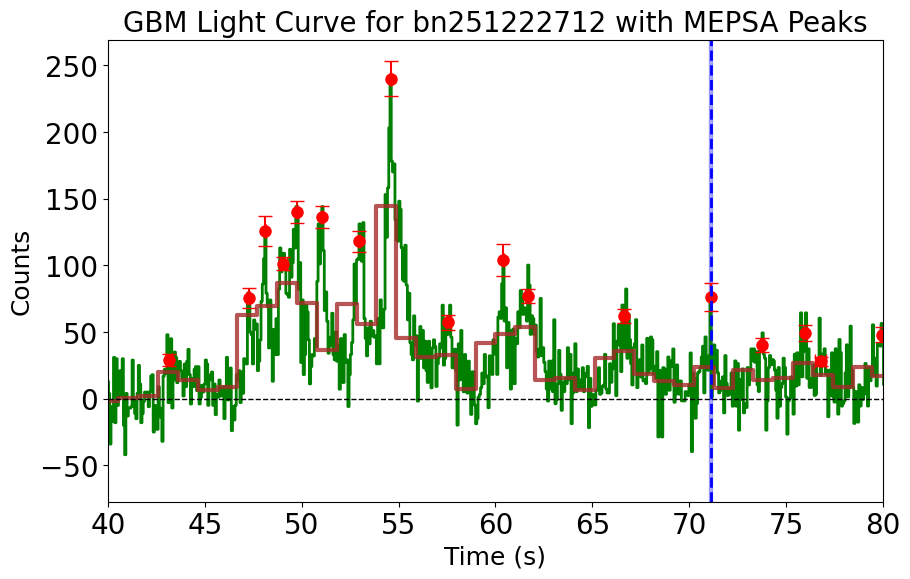

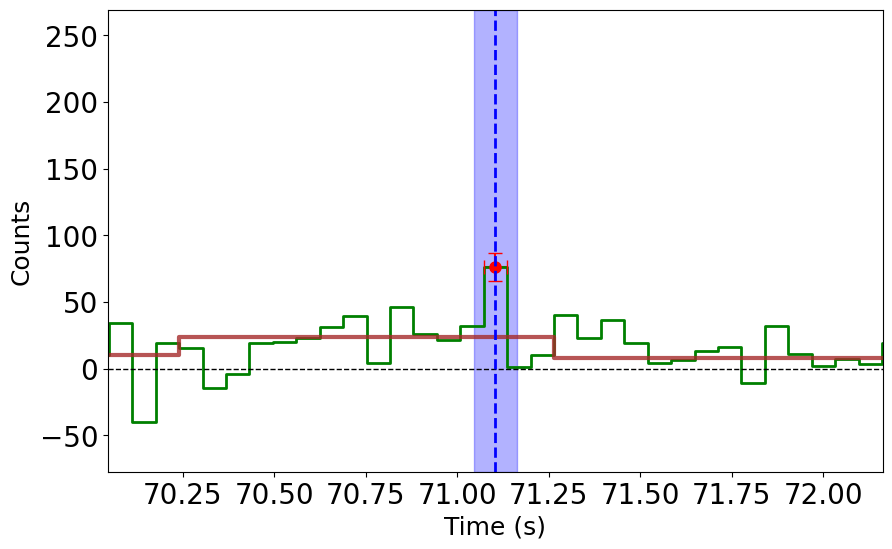

In [24]:
SNmin_1024 = 6
SNmin_64 = 6.4
SNmin_4 = 6.8
SNmin_1 = 7
if bin_time == 1.024:
    SNmin = SNmin_1
elif bin_time == 0.064:
    SNmin = SNmin_64
elif bin_time == 0.004:
    SNmin = SNmin_4
elif bin_time == 0.001:
    SNmin = SNmin_1
else:
    print("No SNR threshold defined for this binning")
# exclude snr <SNmin

df_mepsa = df_mepsa[df_mepsa['SNR'] >= SNmin]
# look at min rebin factor
min_rebf = df_mepsa['RebinFactor'].min()
min_rebf
if min_rebf > 2:
    print(f"REbf_min= {min_rebf}", ">> You can compute the MVT at this binning.")
else:
    print("Bin time is too large to compute MVT, go to smaller binning.")

df_mepsa['FWHM']=  10**(-0.31)*df_mepsa["BinTime"]*(df_mepsa["SNR"]/4.7-1)**(0.60)*df_mepsa["Adjacents"]**(1.06)
idx_mvt = df_mepsa['FWHM'].idxmin()
MVT = df_mepsa['FWHM'].min()
sigma_MVT_plus = df_mepsa['FWHM']*(10**(0.13)-1)
sigma_MVT_minus = -df_mepsa['FWHM']*(10**(-0.13)-1)
# format MVT and errors to 3 decimal places
MVT,sigma_MVT_plus,sigma_MVT_minus = round(MVT, 3), round(sigma_MVT_plus.min(), 3), round(sigma_MVT_minus.min(), 3)
print(f"MVT = {MVT} +{sigma_MVT_plus} -{abs(sigma_MVT_minus)} s")

# plot the light curve with mepsa peaks and show the pulse that carries the MVT



plt.figure(figsize=(10,6))
plt.step(time_cut+bin_time/2, counts_no_bkgd_tot_cut, where='mid', label='Background Subtracted Counts', color='green', linewidth=2)
plt.plot(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values, 'ro', label='MEPSA Peaks', markersize=8)
plt.errorbar(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,xerr= df_mepsa['BinTime'].values/2, yerr=df_mepsa['PeakRateError'].values, fmt='none', ecolor='red', capsize=5)

# plot rebin version
rebff= 16
xrebb,yrebb,zrebb = rebin_lc_genau(time_cut, counts_no_bkgd_tot_cut, err_counts_tot_cut, rebff, ren=True)
plt.step(xrebb,yrebb, where='mid', label='Background Subtracted Counts Rebinned', color='brown', linewidth=3, alpha=0.8)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(df_mepsa.loc[idx_mvt,'PeakTime'], color='blue', linestyle='--', linewidth=2, label='MVT Carrying Pulse')
plt.axvspan(df_mepsa.loc[idx_mvt,'PeakTime'] - df_mepsa.loc[idx_mvt,'FWHM']/2, df_mepsa.loc[idx_mvt,'PeakTime'] + df_mepsa.loc[idx_mvt,'FWHM']/2, color='blue', alpha=0.3)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(40,80)
plt.title(f'GBM Light Curve for {fermi_id} with MEPSA Peaks', fontsize=20)

# do a second plot zoomed on the MVT pulse
plt.figure(figsize=(10,6))
plt.step(time_cut+bin_time/2, counts_no_bkgd_tot_cut, where='mid', label='Background Subtracted Counts', color='green', linewidth=2)
plt.plot(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values, 'ro', label='MEPSA Peaks', markersize=8)
plt.errorbar(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,xerr= df_mepsa['BinTime'].values/2, yerr=df_mepsa['PeakRateError'].values, fmt='none', ecolor='red', capsize=5)

plt.step(xrebb,yrebb, where='mid', label='Background Subtracted Counts Rebinned', color='brown', linewidth=3, alpha=0.8)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(df_mepsa.loc[idx_mvt,'PeakTime'], color='blue', linestyle='--', linewidth=2, label='MVT Carrying Pulse')
plt.axvspan(df_mepsa.loc[idx_mvt,'PeakTime'] - df_mepsa.loc[idx_mvt,'FWHM']/2, df_mepsa.loc[idx_mvt,'PeakTime'] + df_mepsa.loc[idx_mvt,'FWHM']/2, color='blue', alpha=0.3)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(df_mepsa.loc[idx_mvt,'PeakTime'] - 9*df_mepsa.loc[idx_mvt,'FWHM'], df_mepsa.loc[idx_mvt,'PeakTime'] + 9*df_mepsa.loc[idx_mvt,'FWHM'])

/tmp/ipykernel_793806/2400719090.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
No handles with labels found to put in legend.


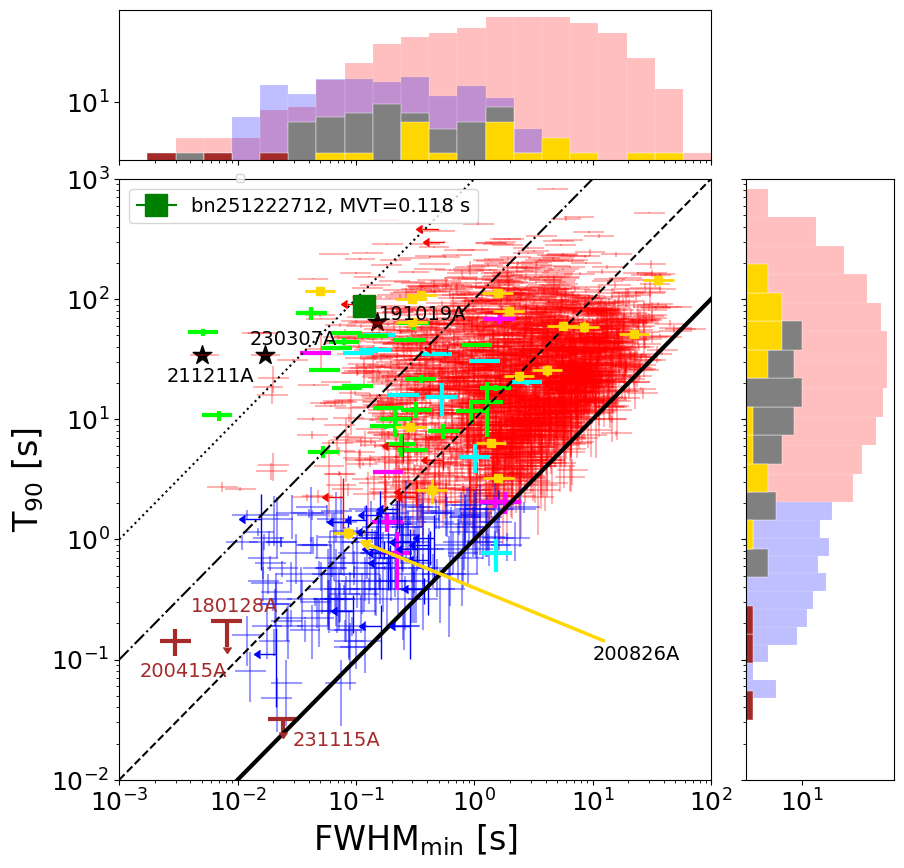

In [49]:
import matplotlib.gridspec as gridspec

def plot_MVT_(MVT_value,T90_value):

    # get the rows of df_long corresponding to these candidates

    df_missing_uplims = pd.read_csv('/astrodata/romain/MVT_GBM_paper/missing_grbs_uplims.txt', sep='\s+', header=None, names=['fermi_id','t90','et90','t90_start','FWHM','sig_FWHM_m','sig_FWHM_p'])
    df_missing_uplims=df_missing_uplims[df_missing_uplims.t90>1.5*df_missing_uplims.et90]
    df_missing_uplims_short = df_missing_uplims[df_missing_uplims.t90 < 2]
    df_missing_uplims_long = df_missing_uplims[df_missing_uplims.t90 >= 2]

    df_missing_vals = pd.read_csv('/astrodata/romain/MVT_GBM_paper/missing_grbs_vals.txt', sep='\s+', header=None, names=['fermi_id','t90','et90','t90_start','FWHM','sig_FWHM_m','sig_FWHM_p'])
    df_missing_vals
    # remove bn190508987, it is not a real missing value
    df_missing_vals = df_missing_vals[df_missing_vals.fermi_id != 'bn190508987']
    # remove GRB111220A, it is not a real missing value
    df_missing_vals = df_missing_vals[df_missing_vals.fermi_id != 'bn111220486']
    df_grb_web = pd.read_csv('/astrodata/romain/MVT_GBM_paper/GRB_web_name.txt', sep='\s+',names=['GRB','fermi_id'])
    df_grb_web

    df_merge = pd.merge(df_missing_vals, df_grb_web, on='fermi_id')
    df_merge
    # reorganize the columns to have GRB in second position
    df_merge = df_merge[['fermi_id', 'GRB', 't90', 'et90', 't90_start', 'FWHM', 'sig_FWHM_m', 'sig_FWHM_p']]
    df_merge

    path_fwhm_file = '/astrodata/romain/MVT_GBM_paper/FWHM_min_Fermi_all_GRBs_rem_wt90_wGRBname.txt'
    df2 = pd.read_csv(path_fwhm_file,sep='\s+',names=['fermi_id','GRB','t90','et90','t90_start','FWHM','sig_FWHM_m','sig_FWHM_p'])
    df = pd.concat([df_merge, df2], ignore_index=True)

    #df=df[df.t90>1*df.et90]
    SNGRBs =np.loadtxt('/astrodata/romain/MVT_GBM_paper/SNGRBs.txt',dtype=str)
    SNGRBs = ['GRB' + s for s in SNGRBs]
    df_long = df[df.t90>2]
    df_long = df_long[df_long.t90>1.5*df_long.et90]
    df_short = df[(df.t90<2)]
    df_short = df_short[df_short.t90>1.5*df_short.et90]


    magnetar_GFs = ['GRB180128A','GRB200415A','GRB231115A']
    long_mergers=['GRB191019A','GRB211211A','GRB230307A']
    kaneko_grbs = np.loadtxt('/astrodata/romain/MVT_GBM_paper/KanekoSEEGRBs.txt',dtype=str)
    # exclude 090927A from kaneko_grbs
    kaneko_grbs = kaneko_grbs[kaneko_grbs != 'bn090927422']
                            
    lan_grbs = np.loadtxt('/astrodata/romain/MVT_GBM_paper/LanSEEGRBs.txt',dtype=str)
    lien_grbs = np.loadtxt('/astrodata/romain/MVT_GBM_paper/LienSEEGRBs.txt',dtype=str)

    df_kaneko = df[df['fermi_id'].isin(kaneko_grbs)]
    df_kaneko = df_kaneko[df_kaneko.t90>1.2*df_kaneko.et90]
    df_lan    = df[df['fermi_id'].isin(lan_grbs)]
    df_lan    = df_lan[df_lan.t90>1.2*df_lan.et90]
    df_lien   = df[df['fermi_id'].isin(lien_grbs)]
    df_lien   = df_lien[df_lien.t90>1.2*df_lien.et90]
    # concatenate all SEE GRBs from lan kaneko and lien
    df_SEE = pd.concat([df_kaneko, df_lan, df_lien])

    df_magnetars = df[df['GRB'].isin(magnetar_GFs)]
    df_long_mergers = df[df['GRB'].isin(long_mergers)]
    df_SNGRB = df[df['GRB'].isin(SNGRBs)]

    fig = plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 18})

    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                        wspace=0.095, hspace=0.05)

    # Define axes
    ax_scatter = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)



    bins=np.logspace(-3,2,22)
    ax_histx.hist(df_long.FWHM, bins=bins,color='red',alpha=0.25,edgecolor='white',lw=0.3)
    ax_histx.hist(df_short.FWHM, bins=bins,color='blue',alpha=0.25,edgecolor='white',lw=0.3)



    ax_histx.hist(df_SEE.FWHM, bins=bins,color='grey',alpha=1,edgecolor='white',lw=0.3)
    ax_histx.hist(df_magnetars.FWHM, bins=bins,color='brown',alpha=1,edgecolor='white',lw=0.3)
    # ax_histx.hist(df_kaneko.FWHM, bins=bins,color='cyan',alpha=0.5)
    # #add lan_grbs
    # ax_histx.hist(df_lan.FWHM, bins=bins,color='lime',alpha=0.5)
    # #add lien_grbs
    # ax_histx.hist(df_lien.FWHM, bins=bins,color='darkblue',alpha=0.5)
    ax_histx.hist(df_SNGRB.FWHM, bins=bins,color='gold',alpha=1,edgecolor='white',lw=0.3)


    bins_t90=np.logspace(-1.5,3,20)

    ax_histy.hist(df_long.t90, bins=np.logspace(np.log10(np.min(df_long.t90)),np.log10(np.max(df_long.t90)),12),color='red',alpha=0.25, orientation='horizontal',edgecolor='white',lw=0.3)
    ax_histy.hist(df_short.t90, bins=np.logspace(np.log10(np.min(df_short.t90)),np.log10(np.min(df_long.t90)),12),color='blue',alpha=0.25, orientation='horizontal',edgecolor='white',lw=0.3)
    ax_histy.hist(df_SEE.t90, bins=bins_t90,color='grey',alpha=1, orientation='horizontal',edgecolor='white',lw=0.3)
    ax_histy.hist(df_SNGRB.t90, bins=bins_t90,color='gold',alpha=1, orientation='horizontal',edgecolor='white',lw=0.3)
    ax_histy.hist(df_magnetars.t90, bins=bins_t90,color='brown',alpha=1, orientation='horizontal',edgecolor='white',lw=0.3)
    # #add lan_grbs
    # ax_histy.hist(df_lan.t90, bins=np.logspace(np.log10(np.min(df_lan.t90)),np.log10(np.max(df_lan.t90)),10),color='lime',alpha=0.5, orientation='horizontal')
    # #add lien_grbs
    # ax_histy.hist(df_lien.t90, bins=np.logspace(np.log10(np.min(df_lien.t90)),np.log10(np.max(df_lien.t90)),10),color='darkblue',alpha=0.5, orientation='horizontal')

    ax_histx.set_xscale('log')
    ax_histx.set_yscale('log')

    ax_histy.set_xscale('log')
    ax_histy.set_yscale('log')


    #ax_histy.hist(y, bins=30, orientation='horizontal', color='gray')


    ax_scatter.scatter(df_long_mergers.FWHM,df_long_mergers.t90,c='k',s=200,marker='*')

    fwhm_1910,t90_1910 = 0.150,64
    ax_scatter.scatter(fwhm_1910,t90_1910,c='k',s=200,marker='*')
    # annotate 
    ax_scatter.text(1.05*fwhm_1910,1.05*t90_1910,'191019A',color='k',size=14)

    ks_x,ks_y=[0.5,0.75],[0.6,1.2]
    for i in range(2):

        wrt = df_long_mergers.GRB.values[i]
        ax_scatter.text(ks_x[i]*df_long_mergers.FWHM.values[i],ks_y[i]*df_long_mergers.t90.values[i],wrt[3:],color='k',size=14)

    ax_scatter.errorbar(df_long.FWHM,df_long.t90,xerr=[-df_long.sig_FWHM_m,df_long.sig_FWHM_p],yerr=df_long.et90,ls='',c='r',alpha=0.3)
    ax_scatter.errorbar(df_short.FWHM,df_short.t90,xerr=[-df_short.sig_FWHM_m,df_short.sig_FWHM_p],yerr=df_short.et90,ls='',c='b',alpha=0.4)


    ax_scatter.plot(np.array([1e-3,1e3]),np.array([1e-3,1e3]),c='k',lw=3)
    ax_scatter.plot(np.array([1e-3,1e3]),10*np.array([1e-3,1e3]),c='k',lw=1.5,ls='--')
    ax_scatter.plot(np.array([1e-3,1e3]),100*np.array([1e-3,1e3]),c='k',lw=1.5,ls='dashdot')
    ax_scatter.plot(np.array([1e-3,1e3]),1000*np.array([1e-3,1e3]),c='k',lw=1.5,ls='dotted')


    #ax_scatter.errorbar(df_magnetars.FWHM.values[0],df_magnetars.t90.values[0],uplims=True,xerr=[-df_magnetars.sig_FWHM_m.values[0],df_magnetars.sig_FWHM_p.values[0]],yerr=df_magnetars.et90.values[0],ls='',c='brown',lw=3)

    # I want to plot only the last two magnetars with upper limits and the first one with error bars
    # but I want to keep the error bars for the first one
    # so I will loop through the magnetars and plot them one by one
    # and I will plot the first one with error bars and the others with upper limits
    for i in range(3):
        if i == 1:
            ax_scatter.errorbar(
                df_magnetars.FWHM.values[i],
                df_magnetars.t90.values[i],
                xerr=[[-df_magnetars.sig_FWHM_m.values[i]], [df_magnetars.sig_FWHM_p.values[i]]],
                yerr=df_magnetars.et90.values[i],
                ls='', c='brown', lw=3
            )
        else:
            ax_scatter.errorbar(
                df_magnetars.FWHM.values[i],
                df_magnetars.t90.values[i],
                xerr=[[-df_magnetars.sig_FWHM_m.values[i]], [df_magnetars.sig_FWHM_p.values[i]]],
                yerr=df_magnetars.et90.values[i]/5,
                c='brown', lw=3, uplims=True,  # <-- use this if t90 is an upper limit
            )
    ax_scatter.errorbar(df_kaneko.FWHM,df_kaneko.t90,xerr=[-df_kaneko.sig_FWHM_m,df_kaneko.sig_FWHM_p],yerr=df_kaneko.et90,ls='',c='cyan',lw=3)
    ax_scatter.errorbar(df_lan.FWHM,df_lan.t90,xerr=[-df_lan.sig_FWHM_m,df_lan.sig_FWHM_p],yerr=df_lan.et90,ls='',c='lime',lw=3)
    ax_scatter.errorbar(df_lien.FWHM,df_lien.t90,xerr=[-df_lien.sig_FWHM_m,df_lien.sig_FWHM_p],yerr=df_lien.et90,ls='',c='magenta',lw=3,alpha=1)
                

    ax_scatter.errorbar(df_missing_uplims_long.FWHM.values,df_missing_uplims_long.t90.values,xerr=[-df_missing_uplims_long.sig_FWHM_m.values, df_missing_uplims_long.sig_FWHM_p.values],yerr=df_missing_uplims_long.et90.values,c='red',ls='', lw=1., xuplims=True)  # <-- use this if t90 is an upper limit
    ax_scatter.errorbar(df_missing_uplims_short.FWHM.values,df_missing_uplims_short.t90.values,xerr=[-df_missing_uplims_short.sig_FWHM_m.values, df_missing_uplims_short.sig_FWHM_p.values],yerr=df_missing_uplims_short.et90.values,c='blue',ls='', lw=1., xuplims=True)  # <-- use this if t90 is an upper limit

    ax_scatter.errorbar(df_SNGRB.FWHM,df_SNGRB.t90,xerr=[-df_SNGRB.sig_FWHM_m,df_SNGRB.sig_FWHM_p],yerr=df_SNGRB.et90,ls='',c='gold',lw=2)
    ax_scatter.plot(df_SNGRB.FWHM.values,df_SNGRB.t90.values,'s',c='gold')
    # find a flashy color for the candidates

    #for j in range(len(df_candidates)):
    #    ax_scatter.plot(df_candidates.FWHM.values[j],df_candidates.t90.values[j],'o',c=df_candidates.color.values[j],ms=8,mec='k',mew=1,label='GRB '+df_candidates.GRB_name.values[j])
    #ax_scatter.plot(df_candidates.FWHM,df_candidates.t90,'X',c='grey',ms=12)
    #ax_scatter.errorbar(df_candidates.FWHM,df_candidates.t90,xerr=[-df_candidates.sig_FWHM_m,df_candidates.sig_FWHM_p],yerr=df_candidates.et90,ls='',c='pink',lw=2)

    ks_x,ks_y = [0.5,0.5,1.2],[1.2,0.5,0.6]
    for i in range(3):
        wrt=df_magnetars.GRB.values[i]
        ax_scatter.text(ks_x[i]*df_magnetars.FWHM.values[i],ks_y[i]*df_magnetars.t90.values[i],wrt[3:],color='brown',size=14)




    ax_scatter.set_xlabel(r'${\rm FWHM_{min}}$'+' [s]',size=24)
    ax_scatter.set_ylabel(r'${\rm T_{90}}$'+' [s]',size=24)

    ax_scatter.loglog()
    ax_scatter.set_xlim(1e-3,100)
    ax_scatter.set_ylim(1e-2,1000)
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)
    fig.tight_layout()

    ax_scatter.annotate('200826A',
                xy=(0.1, 1),             # Point to annotate
                xytext=(10, 0.1),       # Position of the annotation text
                arrowprops=dict(arrowstyle='->', color='gold', lw=2.5),
                fontsize=14,
                color='k')

    fig.legend(fontsize=8,bbox_to_anchor=(0.25,0.7))

    ax_scatter.plot([MVT_value], [T90_value], marker='s', markersize=16, color='green',label=f'{ fermi_id}, MVT={MVT} s')
    ax_scatter
#    plt.show()
    ax_scatter.legend(fontsize=14, loc='upper left')


plot_MVT_(MVT,t90)

Text(0.5, 1.0, 'GBM Light Curve for bn251222712 with MEPSA Peaks')

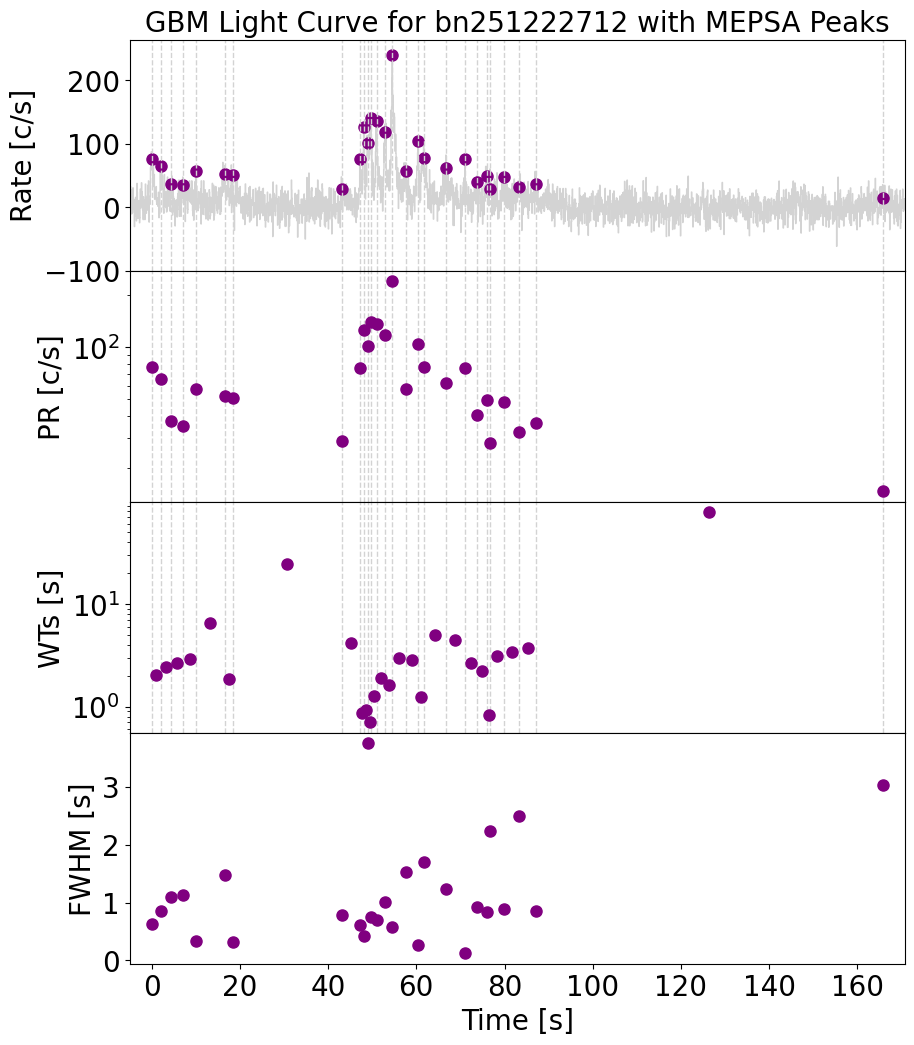

In [383]:
# compute waiting times between peaks
waiting_times = df_mepsa['PeakTime'].values[1:] - df_mepsa['PeakTime'].values[:-1]
# compute medium time between peaks
med_time = 0.5*(df_mepsa['PeakTime'].values[1:] + df_mepsa['PeakTime'].values[:-1])
# make a three panel plot with peak rate, waiting time and fwhm versus peak time
fig,axs = plt.subplots(4,1, figsize=(10,12),sharex=True) 
# set vertical space to zero
plt.subplots_adjust(hspace=0)   
data_color='purple'
axs[0].step(time_cut, counts_no_bkgd_tot_cut, where='mid', label='Background Subtracted Counts', color='lightgray', linewidth=1)
axs[0].plot(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,'o',c=data_color, label='MEPSA Peaks', markersize=8)
for t in df_mepsa['PeakTime'].values:
    for i in range(3):
        axs[i].axvline(t, color='lightgray', linestyle='--', linewidth=1)
axs[0].errorbar(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,xerr= df_mepsa['BinTime'].values/2,c=data_color,ls='')
# peak rate
axs[1].plot(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,'o',c=data_color, label='MEPSA Peaks', markersize=8)
axs[1].errorbar(df_mepsa['PeakTime'].values, df_mepsa['PeakRate'].values,xerr= df_mepsa['BinTime'].values/2,c=data_color,ls='')
axs[2].plot(med_time, waiting_times,'o',c=data_color, label='Waiting Times', markersize=8)
axs[3].plot(df_mepsa['PeakTime'].values, df_mepsa['FWHM'].values, 'o', c=data_color, label='FWHM', markersize=8)
axs[0].set_xlim(df_mepsa['PeakTime'].values.min()-5,df_mepsa['PeakTime'].values.max()+5)
axs[0].set_ylim(-100,1.1*counts_no_bkgd_tot_cut.max())
# set logspace for subpanels 1 to 3
for i in range(1,3):
    axs[i].set_yscale('log')

# set tick fontsize
for i in range(4):
    axs[i].tick_params(axis='both', which='major', labelsize=20)

axs[0].set_ylabel('Rate [c/s]', fontsize=20)
axs[1].set_ylabel('PR [c/s]', fontsize=20)
axs[2].set_ylabel('WTs [s]', fontsize=20)
axs[3].set_ylabel('FWHM [s]', fontsize=20)
axs[3].set_xlabel('Time [s]', fontsize=20)
axs[0].set_title(f'GBM Light Curve for {fermi_id} with MEPSA Peaks', fontsize=20)

In [ ]:
# E_p-E_iso without redshift

In [ ]:
# Ep,i-E_iso with redshift 